# Práctica 3: Aprendizaje de modelos basados en redes neuronales

## Minería de Datos

### Curso académico 2023-2024

#### Profesorado:

* Juan Carlos Alfaro Jiménez
* José Antonio Gámez Martín

#### Autores (Grupo: 16):

* Alejandro Sánchez Corredor
* Iván Fernández García

---

En esta práctica, trabajaremos con modelos basados en redes neuronales utilizando, para ello, la librería `tensorflow`. Esta se trata de una de las más populares hoy en día debido a su facilidad de uso y versatilidad.

# 1. Preliminares

En primer lugar, vamos a comprobar que se esté utilizando una tarjeta gráfica. De esta manera se incrementará la capacidad computacional reduciendo así el tiempo de aprendizaje e inferencia de las redes neuronales:

In [1]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Get a list of physical devices visible to the host runtime
device_type = "GPU"  # The device type
devices = tf.config.list_physical_devices(device_type)

if not devices:
    # Raise an informative message when there are no devices in the host runtime
    raise RuntimeError(f"No {device_type} devices are used in the host.")

También fijamos una semilla para lograr que los experimentos sean reproducibles:

La reproducibilidad de los experimentos no está garantizada en `tensorflow` si se utilizan tarjetas gráficas debido a la ejecución en paralelo de determinadas operaciones matemáticas. Si bien es posible asegurar la reproducibilidad, esto se produce a expensas de un menor rendimiento. Por tanto, para evitar esto, mantendremos no determinismo en las ejecuciones.

In [3]:
seed = 27912

Por último, vamos a introducir algunos de los conceptos más importantes que nos encontraremos a lo largo de la práctica:

* *Batch size*: El tamaño de *batch* es número de imágenes de entrenamiento que se utilizarán en una iteración. Mientras que utilizar tamaños más grandes permite acelerar el entrenamiento y requiere más memoria, los tamaños más pequeños tienden a ayudar al modelo a generalizar mejor.

* *Epoch*: Una época se completa cuando se han visto todas las imágenes de entrenamiento una vez, por lo que el número de épocas determina cuantas veces vamos a iterar sobre el conjunto de entrenamiento al completo. Un valor demasiado bajo puede provocar subajuste, mientras que un valor demasiado alto puede provocar sobreajuste.

* *Steps per epoch*: Los pasos en cada época se corresponden con el número de iteraciones de tamaño de *batch* que se realizan en una época. Una de las técnicas habituales al utilizar este parámetro es dividir el número de imágenes de entrenamiento entre el tamaño de *batch*, especialmente con conjuntos de datos grandes.

* *Steps de validación y prueba*: Es el número de pasos en los conjuntos de validación y prueba, es decir, cuántas iteraciones de tamaño de *batch* realizas sobre los conjuntos. Por ejemplo, cuando una época termina y se evalúa el modelo sobre el conjunto de datos de validación, el número de pasos determina cuántas veces se va a procesar el conjunto de validación, necesitando al menos un número de pasos igual a la cantidad de imágenes de validación entre el tamaño de *batch* para procesar todo el conjunto de validación al final de esa época. Es especialmente útil cuando se utiliza un generador de flujo de datos, como será nuestro caso.

* *Learning rate*: La tasa de aprendizaje es un factor que se utiliza para escalar las actualizaciones de los pesos durante el entrenamiento. Un valor más alto acelerará el entrenamiento, mientras que si es más bajo requerirá más tiempo pero convergerá de manera más estable. 



# 2. Carga de datos

En esta práctica, vamos a emplear un conjunto de datos que contiene personajes de "Los Simpson". El objetivo sería identificar un personaje de "Los Simpson" en una imagen de entre los 25 disponibles:

* Homer Simpson
* Ned Flanders
* Moe Szyslak
* Lisa Simpson
* Bart Simpson
* Marge Simpson
* Krusty The Clown
* Principal Skinner
* Charles Montgomery Burns
* Milhouse Van Houten
* Chief Wiggum
* Abraham Grampa Simpson
* Sideshow Bob
* Apu Nahasapeemapetilon
* Kent Brockman
* Comic Book Guy
* Edna Krabappel
* Nelson Muntz
* Lenny Leonard
* Mayor Quimby
* Waylon Smithers
* Maggie Simpson
* Groundskeeper Willie
* Barney Gumble
* Selma Bouvier

In [4]:
import os
from pathlib import Path
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Antes de cargar los datos, lo que haremos será una partición estratificada del conjunto de entrenamiento dado en un subconjunto de entrenamiento y otro de validación, ya que al cargar las particiones directamente desde directorio no se realiza una estratificación, lo que podría afectar al rendimiento de nuestros modelos para un problema multiclase desbalanceado. Para ello usaremos la librería `split-folders`, que nos permite, a partir de un directorio, generar uno nuevo que contenga un directorio de entrenamiento, otro de validación y opcionalmente uno de prueba, todos ellos con la misma distribución de clases porque el tamaño de cada subconjunto se aplica a cada una de las clases (por ejemplo, 80% de entrenamiento y 20% de validación para cada clase). En nuestro caso dividiremos solo en entrenamiento y validación, ya que recibimos un conjunto de entrenamiento y el test es un conjunto separado dedicado a la evaluación de los modelos para la competición. La creación de estos directorios también nos facilitará el trabajo a la hora de prevenir fugas cuando hagamos aumento de datos.

In [5]:
!pip install split-folders
import splitfolders

In [6]:
competition = "predict-the-simpsons-characters"  # The unique name of the competition
root = Path("..") / "input" / competition  # Directory with the subsets of the data ("kaggle/input/predict-the-simpsons-characters")

input = Path(root) / "train" # Directory to split ("kaggle/input/predict-the-simpsons-characters/train")
output = Path(".") / "stratified_data" # New directory ("kaggle/working/stratified_data")
train_size = 0.8    # Fraction for train
validation_size = 0.2  # Fraction for validation

if not os.path.exists(output):
    # Divide in train and validation folders
    splitfolders.ratio(input, output=output, ratio=(train_size, validation_size), seed=seed)
else:
    raise Warning(f"'{str(output)}' directory already exists.")

Copying files: 16137 files [01:19, 201.72 files/s]


Una vez hecho esto ya podemos cargar los datos desde los directorios correspondientes.

**Importante**: Más adelante se realizará un aumento de datos sobre el conjunto de entrenamiento y se volverán a cargar las imágenes a través de un generador de flujo con los cambios, pero primero crearemos un dataset con las originales, puesto que uno de nuestros modelos no utilizará el aumento de datos. Como este no se aplica a las imágenes de validación ni a las de test, estas sólo se cargarán así.

En primer lugar, como preparación de los datos, crearemos un generador de flujo que únicamente contará con reescalado para acelarar el proceso. A partir de este cargarán las imágenes de entrenamiento (sin aumento de datos), las de validación y las de prueba.

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

Comenzamos cargando el conjunto de entrenamiento:

In [8]:
directory = Path(".") / "stratified_data" / "train"  # Directory where the data is located ("kaggle/working/stratified_data/train")
batch_size = 32  # Size of the batches of data
target_size = (256, 256)  # Size to resize images to after they are read from disk

# Generate the training dataset from image files in the corresponding directory
train = datagen.flow_from_directory(directory, batch_size = batch_size, target_size = target_size, seed = seed)

Found 12899 images belonging to 25 classes.


Hacemos lo mismo para el conjunto de prueba:

In [9]:
directory = Path(".") / "stratified_data" / "val"  # Directory where the data is located ("kaggle/working/stratified_data/val")

# Generate the validation dataset from image files in the corresponding directory
validation = datagen.flow_from_directory(directory, batch_size = batch_size, target_size = target_size, seed = seed)

Found 3238 images belonging to 25 classes.


Finalizaremos cargando el conjunto de prueba, aunque en este caso no barajaremos los datos. Esto se debe a que a la hora de subir nuestras predicciones a la competición, su orden debe corresponderse con el de los valores reales que desconocemos, para que las imágenes sean las que corresponden y la forma de medir el rendimiento sea coherente.

In [10]:
competition = "predict-the-simpsons-characters"  # The unique name of the competition
root = Path("..") / "input" / competition  # Directory with the subsets of the data ("kaggle/input/predict-the-simpsons-characters")
directory = Path(root) / "test" # Directory where the data is located ("kaggle/input/predict-the-simpsons-characters/test")
shuffle = False  # Whether to shuffle the data

# Generate the testing dataset from image files in the corresponding directory
test = datagen.flow_from_directory(directory, batch_size = batch_size, target_size = target_size, seed = seed, shuffle = shuffle)

Found 4050 images belonging to 1 classes.


Una vez tenemos preparados los conjuntos de datos de entrenamiento, validación y prueba, vamos a visualizar algunas de las imágenes. Recordemos que todavía no se ha realizado el aumento de datos sobre el conjunto de entrenamiento.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

Para ello utilizaremos el siguiente método:

In [12]:
def plot_images(directory_iterator, size=(3,3)):
    rows, columns = size
    figsize = (10, 10)
    plt.figure(None, figsize)

    # Take one batch from the directory iterator
    images, labels = next(directory_iterator)

    # Get the class names from the directory iterator
    classes = directory_iterator.class_indices
    classes = {v: k for k, v in classes.items()}
    
    for i in range(rows * columns):
        # Transform the tensor to an array
        image = images[i]
        dtype = np.uint8  # Typecode to which the array is cast
        image = (np.array(image) * 255).astype(dtype)  # Revert normalization

        # Get the class name of the image
        label = labels[i]
        label = classes[np.argmax(label)]

        # Visualize the image
        index = i + 1
        option = "off"
        _ = plt.subplot(rows, columns, index)
        plt.imshow(image)
        plt.title(label)
        plt.axis(option)

Las mostramos:

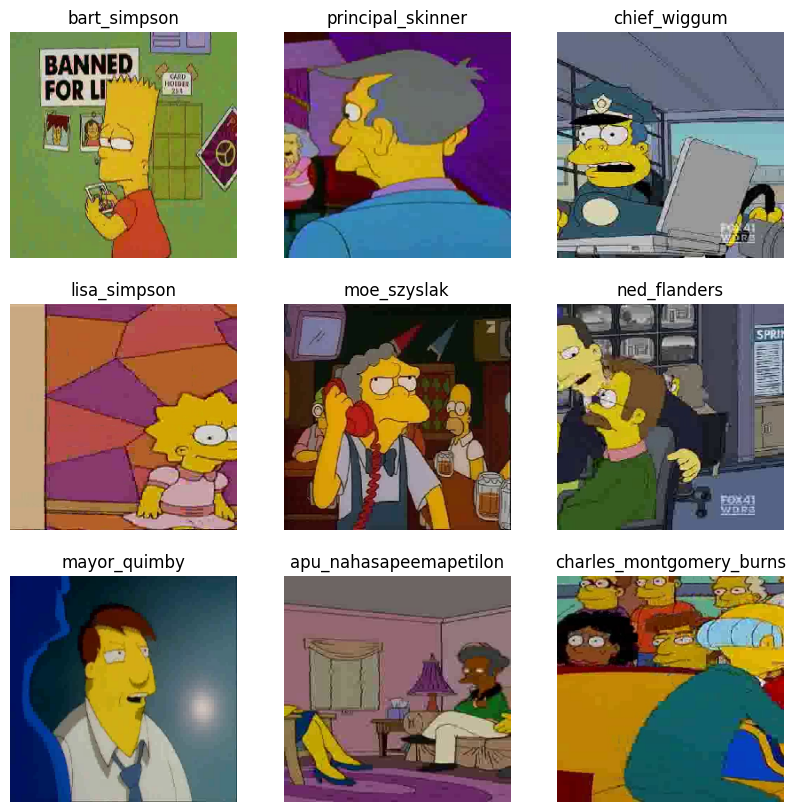

In [13]:
plot_images(train)

Además, vamos a ver cuál es la distribución de la variable clase:

In [14]:
import pandas as pd

In [15]:
classes = np.array([label for label in train.class_indices])
classes

array(['abraham_grampa_simpson', 'apu_nahasapeemapetilon',
       'barney_gumble', 'bart_simpson', 'charles_montgomery_burns',
       'chief_wiggum', 'comic_book_guy', 'edna_krabappel',
       'groundskeeper_willie', 'homer_simpson', 'kent_brockman',
       'krusty_the_clown', 'lenny_leonard', 'lisa_simpson',
       'maggie_simpson', 'marge_simpson', 'mayor_quimby',
       'milhouse_van_houten', 'moe_szyslak', 'ned_flanders',
       'nelson_muntz', 'principal_skinner', 'selma_bouvier',
       'sideshow_bob', 'waylon_smithers'], dtype='<U24')

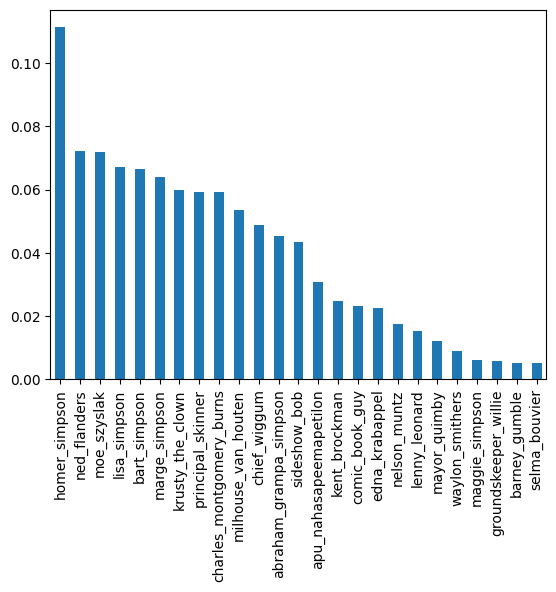

In [16]:
function = lambda file: file.split(os.sep)[2] # Function that obtains the name of the class from an image path
iterable = train.filepaths # Train images paths
generator = map(function, iterable) # Apply function to train images paths

data = list(generator)  # Data to be stored

normalize = True  # Return the relative frequencies of the unique values
sort = True  # Sort by frequencies
kind = "bar"  # The kind of plot to produce

pd.Series(data).value_counts(normalize, sort).plot(kind = kind);

Tal y como se puede observar, la variable clase está desbalanceada. No obstante, y para no complicar la práctica, vamos a usar la tasa de acierto para evaluar el rendimiento de los modelos.

# 3. Modelos basados en redes neuronales

Las *redes neuronales* son un tipo de modelo de aprendizaje automático que tratan de emular el compartamiento del cerebro humano. En esta práctica presentaremos diferentes arquitecturas de redes neuronales para las que utilizaremos varias técnicas que nos ayudarán tanto a reducir el sobreajuste como a acelerar el entrenamiento y mejorar el rendimiento de nuestros modelos frente a ejemplos no observados previamente, en este caso las imágenes del conjunto de prueba de la competición. Algunas de las estrategias son las siguientes:

* *Data Augmentation*
* *Transfer Learning*
* *Fine-tuning*
* Uso de *callbacks* 
* Regularización *Dropout*
* Normalización de *batch*
* Normalización de capas

Antes de comenzar, vamos a crear un diccionario donde almacenar cada uno de los modelos:

In [17]:
from collections import defaultdict

In [18]:
models = defaultdict(dict)

También vamos a crear una capa de entrada para nuestros modelos, la cuál utilizaremos para ahorrarnos tener que especificar el tamaño de entrada en la primera capa del modelo correspondiente:

In [19]:
input_layer = keras.layers.Input(shape=(*target_size, 3))

## 3.1. *Callbacks*

Cuando finaliza el número de *epochs* establecido lo que se guarda es el historial del modelo, pero podemos hacerlo mejor. A través de la clase `Callback` podemos monitorizar los diferentes resultados sobre el conjunto de validación y actuar en consecuencia. Más concretamente, lo que haremos será guardar en un archivo el mejor modelo sobre el conjunto de validación y además estableceremos un número máximo de épocas sin mejoras en 'val_loss' para interrumpir el entrenamiento y así acelerar el proceso.

La idea es pasar a nuestros modelos una lista con los callbacks que realicen ambas funciones, pero para no sobreescribir el archivo con el mismo nombre cada vez que entrenemos, lo que haremos será crear un método que reciba por parámetro el nombre del archivo del modelo a guardar y cree los callbacks devolviendo una lista que los contenga. También puede ser una buena opción pasarle el número máximo de épocas sin mejora antes de detener el entrenamiento en vez de que sea fijo. Podemos hacerlo de la siguiente manera:

In [20]:
def create_callbacks(filepath='best_model.hdf5', patience=5):
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=filepath, # Path of the model be saved
        save_weights_only=False, # Save all the architecture
        verbose=2, # Show messages during training
        save_best_only=True) # Save only the model of the best epoch

    early_stopping_callback = keras.callbacks.EarlyStopping(
        patience=patience, # Max number of epochs without increasing the metric
        restore_best_weights=True, # Restore weights to the best epoch
        verbose=1 # Show messages during training
    )
    
    callbacks = [model_checkpoint_callback, early_stopping_callback]
    return callbacks

## 3.2. *Data Augmentation*

Lo primero que haremos para reducir el sobreajuste será un aumento de datos. Este se realizará únicamente sobre el train y nos permitirá disponer de más ejemplos, ya que incrementaremos el número de ellos a través de pequeñas modificaciones en las imágenes originales.

**Importante**: Si utilizamos directamente las capas de preprocesamiento de `TensorFlow` como parte de nuestro modelo, el aumento de datos podría aplicarse también al resto de los datos. Como queremos garantizar que esto no ocurra, lo que haremos será volver a cargar los datos de entrenamiento desde directorio, pero esta vez usando un `ImageDataGenerator` que contenga las nuevas modificaciones más allá del escalado. De este modo generamos las imágenes de cada uno de los conjuntos de datos de la forma que le corresponde, y el aumento de datos sólo se aplica al entrenamiento, ya que ahora no es un paso de nuestro modelo. Respecto a los datos de entrenamiento a los que no se le aplicó el aumento, los mantendremos para utilizarlos en alguno de nuestros modelos y comparar los resultados, como ya se comentó anteriormente.

Podemos realizar el aumento de datos de la siguiente manera:

In [21]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

Vamos a comprobar que funciona correctamente aplicándoselo a algunas imágenes de ejemplo. Para ello utilizamos el siguiente método:

In [22]:
def plot_data_augmentation_example(image_path):
    img = load_img(image_path) # Load image from path
    img_array = img_to_array(img) # Transform to array
    x = img_array.reshape((1,) + img_array.shape) # Reshape for appropiate format
    
    # Create figure to plot
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace=0, hspace=0)
    
    i = 0
    # Show images with data augmentation changes
    for batch in data_augmentation.flow(x, batch_size=1):
        plt.subplot(3, 5, i+1)
        plt.axis('off')
        plt.imshow((batch * 255.0).clip(0, 255).astype(int).reshape(img_array.shape))
        if i == 9:
            break
        i += 1
    
    plt.show()

Tomamos algunas imágenes de muestra y vemos cómo se le aplica el aumento de datos:

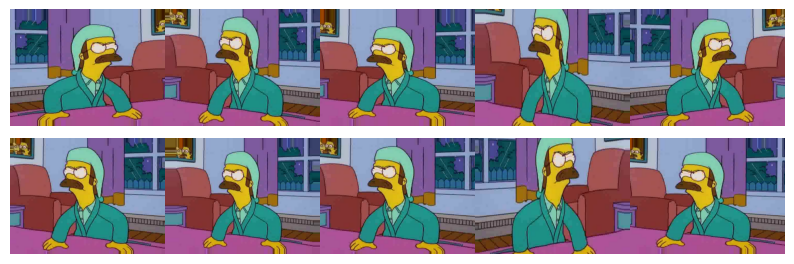

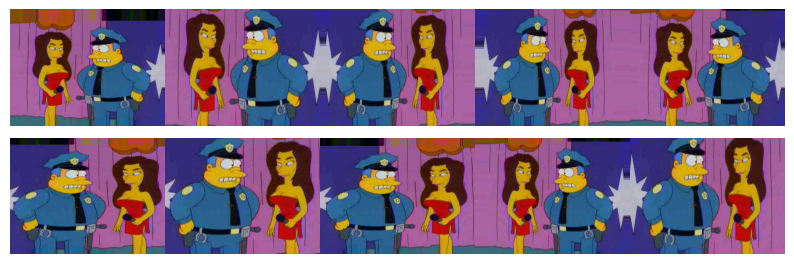

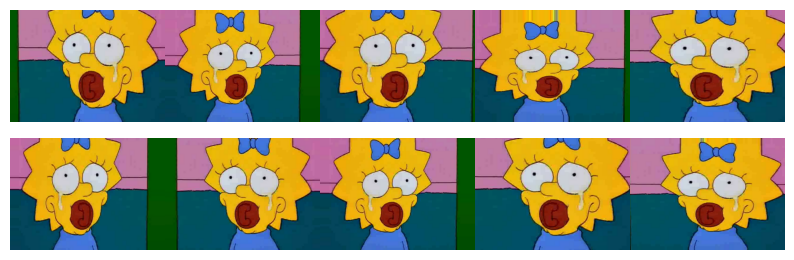

In [23]:
example_paths = [
    "stratified_data/train/ned_flanders/pic_1157.jpg",
    "stratified_data/train/chief_wiggum/pic_0288.jpg",
    "stratified_data/train/maggie_simpson/pic_0065.jpg"
]

for path in example_paths:
    plot_data_augmentation_example(path)

Cargamos los datos de entrenamiento, esta vez aplicando el aumento de datos:

In [24]:
directory = Path(".") / "stratified_data" / "train"  # Directory where the data is located ("kaggle/working/stratified_data/train")

# Generate the training dataset from image files in the corresponding directory
train_augmented = data_augmentation.flow_from_directory(directory, batch_size = batch_size, target_size = target_size, seed = seed)

Found 12899 images belonging to 25 classes.


De esta forma, siempre que entrenemos un modelo en el que queramos hacer aumento de datos bastará con pasarle `train_augmented` al método `fit`. Por otra parte, cuando especifiquemos los datos de validación, estos se generarán únicamente con reescalado de acuerdo al generador de flujo que le asignamos durante la carga de datos, por lo que no le afectará el aumento de datos. Realizar el proceso de esta manera es muy importante, pues el aumento de datos sólo debe hacerse sobre el conjunto de entrenamiento.

## 3.3. *Transfer Learning*:

En lugar de crear redes convolucionales y entrenarlas desde cero, se puede utilizar una técnica habitual conocida como *Transfer Learning*. Esta consiste en usar modelos que ya han sido entrenados previamente con grandes conjuntos de datos, de forma que se extraen las características aprendidas por la red neuronal y después del vector de características profundas se aborda el problema en cuestión añadiendo capas completamente conectadas, o "fully connected".

Además, a esta estrategia se le puede hacer ***Fine-tuning***. Esto nos permite hacer un pequeño ajuste en los pesos de las capas convolucionales, permitiendo que se actualicen algunas de las capas superiores del extractor de características para entrenarlas junto al clasificador, lo que se conoce como "descongelar" algunas capas adicionales que sí podrán entrenarse. Es recomendable utilizar esta técnica cuando ya se haya entrenado un poco el clasificador, ya que existe el riesgo que las actualizaciones de los pesos sean tan grandes que se destruya la información de las capas superiores del extractor. Debido a esto, en nuestro caso siempre realizaremos un entrenamiento previo antes de aplicarlo.

En este caso, al contrario que con los *callbacks* y *Data Augmentation*, la creación de las convoluciones base que emplearemos se realizará directamente en el apartado correspondiente a la creación de los modelos, junto a una explicación más detallada de todo el proceso.

## 3.4. Creación de modelos

A la hora de crear nuestros diferentes modelos de redes neuronales, hemos intentado cubrir las diferentes posibilidades y probar las estrategias que se suelen utilizar habitualmente, de forma que podamos comparar los resultados y sacar conclusiones en base a ello.

Dado que el aumento de datos es una de las técnicas habituales para la reducción del sobreajuste a la hora de trabajar con modelos basados en redes neuronales, hemos decidido incluirlo en la mayoría de nuestros modelos. Sin embargo, hemos querido reservar un modelo en el que no se realice para ver qué sucede. Para ello utilizaremos una red neuronal convolucional sencilla.

Dicho esto, hemos optado por la creación de varios modelos diferentes.

___

* Sin *Data Augmentation*:
    
    * Una red neuronal convolucional (CNN) sencilla
    
    
* Con *Data Augmentation*:

    * Una red neuronal convolucional (CNN) sencilla
    * Una red neuronal convolucional (CNN) compleja
    * Una red neuronal utilizando *Transfer Learning*
    * Aplicar *Fine-tuning* al modelo anterior
    
---
    
A partir de estos modelos algunas de las preguntas que podemos hacernos son las siguientes:
    

* *¿Se producirá sobreajuste si no realizamos aumento de datos?*
    
* *¿Realizar aumento de datos reduce el sobreajuste?*

* *¿Qué diferencia a una CCN compleja de una CNN simple y por qué ofrece mejores resultados?*

* *¿Utilizar Transfer Learning nos ofrece mejores resultados que crear una red neuronal desde cero?*

* *¿Qué mejoras ofrece aplicar Fine-tuning a un modelo que utiliza Transfer Learning?*
    


### Red neuronal convolucional (CNN) sencilla

Esta arquitectura es la única que se va a probar sin realizar el aumento de datos. Aunque es la misma en ambos casos porque la diferencia estará en la entrada que utilicemos a la hora de entrenar, crearemos dos modelos idénticos para poder diferenciarlos a la hora de guardarlos.

Las redes neuronales convolucionales están formadas por la siguiente secuencia de capas:
* Capa convolucional
* Capa *ReLU*
* Capa de *pooling*
* Capa completamente conectada

El patrón que se suele seguir habitualmente el siguiente:

* Un número (mayor que cero) de secuencias de una capa convolucional + *ReLU* [+ *pooling*]
* Un número (no mayor que 2) de secuencias de una capa completamente conectada + *ReLU*
* Una capa completamente conectada

Para nuestra red neuronal convolucional simple utilizaremos tres secuencias de una capa convolucional + *ReLU* + *pooling*, aunque sin *pooling* en la última. Estas irán seguidas de una capa de aplanamiento y nuestra capa densa de salida.

Primero creamos la arquitectura común:

In [25]:
simple_cnn = keras.models.Sequential([
    input_layer, # Input layer
    
    # Convolutional layers
    keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
    
    keras.layers.Flatten(), # Flatten layer
    
    # Fully connected layers
    keras.layers.Dense(len(classes), activation="softmax") # Output layer
])

simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 460800)            0

Ahora creamos el primer modelo:

In [26]:
model_name = "model_simple_cnn_without_data_augmentation"
models[model_name]["model"] = simple_cnn

Como optimizador utilizaremos `keras.optimizers.RMSprop` con sus valores por defecto, ya que suele ofrecer buenos resultados.

In [27]:
lr = 0.001 #Learning rate
optimizer = keras.optimizers.RMSprop(lr) # Optimizer
loss = "categorical_crossentropy"  # Loss function
metrics = ["accuracy"]  # List of metrics to be evaluated by the model during training and testing

models[model_name]["model"].compile(optimizer, loss, metrics)

Hacemos lo mismo para el caso en el que utilizaremos aumento de datos, pero clonaremos el modelo para que sea independiente:

In [28]:
model_name = "model_simple_cnn"
models[model_name]["model"] = keras.models.clone_model(simple_cnn)

In [29]:
lr = 0.001 #Learning rate
optimizer = keras.optimizers.RMSprop(lr) # Optimizer
loss = "categorical_crossentropy"  # Loss function
metrics = ["accuracy"]  # List of metrics to be evaluated by the model during training and testing

models[model_name]["model"].compile(optimizer, loss, metrics)

### Red neuronal convolucional (CNN) compleja

Este modelo será muy parecido al anterior, ya que también es una red neuronal convolucional. Sin embargo, en este caso añadiremos una capa completamente conectada + *ReLU* y utilizaremos la regularización *Dropout* para mejorar el rendimiento.

¿Qué es simple y qué es complejo? ¿Cuál es la vara de medir?

Nótese que el cambio que se ha hecho respecto a la red neuronal anterior es bastante pequeño. Siempre existe la posibilidad de añadir más capas convolucionales o densas, pero hemos querido representar el salto de simple a complejo a través de otra capa completamente conectada y *Dropout*.

In [30]:
model_name = "model_complex_cnn"

models[model_name]["model"] = keras.models.Sequential([
    input_layer, # Input layer
    
    # Convolutional layers
    keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
    
    keras.layers.Flatten(), # Flatten layer
    
    # Fully connected layers
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5), # Dropout layer
    keras.layers.Dense(len(classes), activation="softmax") # Output layer
])

models[model_name]["model"].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 460800)           

Utilizamos el mismo optimizador:

In [31]:
lr = 0.001 #Learning rate
optimizer = keras.optimizers.RMSprop(lr) # Optimizer
loss = "categorical_crossentropy"  # Loss function
metrics = ["accuracy"]  # List of metrics to be evaluated by the model during training and testing

models[model_name]["model"].compile(optimizer, loss, metrics)

### Redes neuronales utilizando *Transfer Learning*

Como ya se ha comentado anteriormente, el *Transfer Learning* consiste en apoyarse en modelos ya entrenados previamente con grandes conjuntos de datos en lugar de crear las redes neuronales desde cero. Hablábamos de extraer las características aprendidas por la red neuronal y después del vector de características profundas abordar el problema añadiendo capas completamente conectadas.

Una vez se entrenaba un poco el clasificador, recordemos que era posible ajustar ligeramente los pesos de las capas convolucionales, permitiendo que algunas de las capas superiores del extractor de características se actualizasen para entrenarlas junto al clasificador. A esto lo llamábamos *Fine-tuning*.

Para no dejarnos esto último sin explorar, lo que haremos será crear un modelo que entrenaremos primero sin aplicar *Fine-tuning* y posteriormente "descongelaremos" algunas capas para ver si se produce una mejora.

El modelo preentrenado que hemos seleccionado es el InceptionV3. Este ha sido preentrenado en el conjunto de datos ImageNet y ha demostrado un buen rendimiento en clasificación de imágenes. Es una elección popular debido a su capacidad para capturar características complejas y podemos encontrarlo en `tensorflow.keras.models.InceptionV3`. Se puede encontrar más información sobre la arquitectura en este [enlace](https://cloud.google.com/tpu/docs/inception-v3-advanced?hl=es-419)

Lo primero que haremos será crear la convolución base cargando el modelo preentrenado. Es importante poner su atributo `trainable` a `False`, ya que primero utilizaremos sólo las capas preentrenadas para entrenar nuestro clasificador y no "descongelaremos" ninguna hasta que llegue el momento de aplicar *Fine-tuning*. También es importante cargar el modelo sin la parte del clasificador, por lo que `include_top` también debe ser `False`.


In [32]:
conv_base = keras.applications.InceptionV3(include_top = False, weights = "imagenet")
conv_base.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


Crear el modelo es muy sencillo, pues lo único que tenemos que hacer es especificar los inputs y los outputs. En este caso los inputs se corresponden con la entrada del modelo preentrenado, pues recordemos que no le preceden capas y el aumento de datos se realiza directamente al entrenar con el generador. Por su parte, los outputs deben ser las predicciones resultantes, que se obtienen a partir de nuestra capa de salida. Esta última se encuentra precedida por la salida del modelo preentrenado y entre medias debemos situar nuestras capas completamente conectadas, que en nuestro caso estarán formadas por una única capa densa con activación *ReLU*.

In [33]:
model_name = "model_transfer_learning"

x = conv_base.output # InceptionV3 output

x = keras.layers.GlobalMaxPooling2D()(x) # Similar to flatten but reduces the number of param

# Fully connected layers
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(len(classes), activation="softmax")(x) # Output layer

inputs = conv_base.input # InceptionV3 input as inputs
outputs = x # Predictions as outputs

models[model_name]["model"] = keras.Model(inputs,outputs)
models[model_name]["model"].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d_6[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

Para el primer entrenamiento utilizaremos `keras.optimizers.Adam` con sus valores por defecto:

In [34]:
optimizer = "adam" # Optimizer
loss = "categorical_crossentropy"  # Loss function
metrics = ["accuracy"]  # List of metrics to be evaluated by the model during training and testing

models[model_name]["model"].compile(optimizer, loss, metrics)

# 4. Modelado y validación

Después de crear todos nuestros modelos, el siguiente paso es realizar el proceso de modelado y validación. Entrenaremos los modelos durante un número de épocas, a la vez que utilizamos el conjunto de validación para medir la tasa de acierto respecto a un conjunto de datos no observado previamente que nos ayudará a estimar cómo de preparados están nuestros modelos para la competición.

In [35]:
!pip install plot_keras_history
from plot_keras_history import plot_history

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=28ae75ed546391c8c347e2f4130f2fa33175a0e1d27bd6eb9630bf353a7eeebb
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=99f611a6303e02576a036a7b9daf18a2f046e9c91be94bd20d53fc11cd3b03a4
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5629 sha256=215b04d90fc2b90552a5ef548ad299b3eee1b7834b23ae95d42632e20ed5be2d
  St

Como los parámetros pueden variar para cada modelo, entrenaremos cada uno de forma independiente y no en un bucle. Posteriormente mostraremos su historial y analizaremos los resultados.

### Red neuronal convolucional (CNN) sencilla **(Sin aumento de datos)**
Vamos a entrenar el primer modelo de la forma que se indica a continuación. Nótese que el conjunto de entrenamiento es el que utiliza el generador de flujo sin el aumento de datos, sino únicamente el reescalado:

In [36]:
model_name = "model_simple_cnn_without_data_augmentation"

epochs = 20
callbacks = create_callbacks("best_" + model_name.replace(" ", "_") + ".hdf5", 5)

models[model_name]["history"] = models[model_name]["model"].fit(
    x = train,
    validation_data = validation,
    epochs = epochs,
    callbacks=callbacks
)

Epoch 1/20
404/404 [==============================] - ETA: 0s - loss: 2.0948 - accuracy: 0.4280
Epoch 1: val_loss improved from inf to 1.55918, saving model to best_model_simple_cnn_without_data_augmentation.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


404/404 [==============================] - 46s 90ms/step - loss: 2.0948 - accuracy: 0.4280 - val_loss: 1.5592 - val_accuracy: 0.5723
Epoch 2/20
404/404 [==============================] - ETA: 0s - loss: 1.0160 - accuracy: 0.7213
Epoch 2: val_loss improved from 1.55918 to 1.22274, saving model to best_model_simple_cnn_without_data_augmentation.hdf5
404/404 [==============================] - 35s 87ms/step - loss: 1.0160 - accuracy: 0.7213 - val_loss: 1.2227 - val_accuracy: 0.6742
Epoch 3/20
404/404 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.9070
Epoch 3: val_loss did not improve from 1.22274
404/404 [==============================] - 34s 83ms/step - loss: 0.3292 - accuracy: 0.9070 - val_loss: 1.4422 - val_accuracy: 0.6677
Epoch 4/20
404/404 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9692
Epoch 4: val_loss did not improve from 1.22274
404/404 [==============================] - 34s 83ms/step - loss: 0.1045 - accuracy: 0.9692 - val_l

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

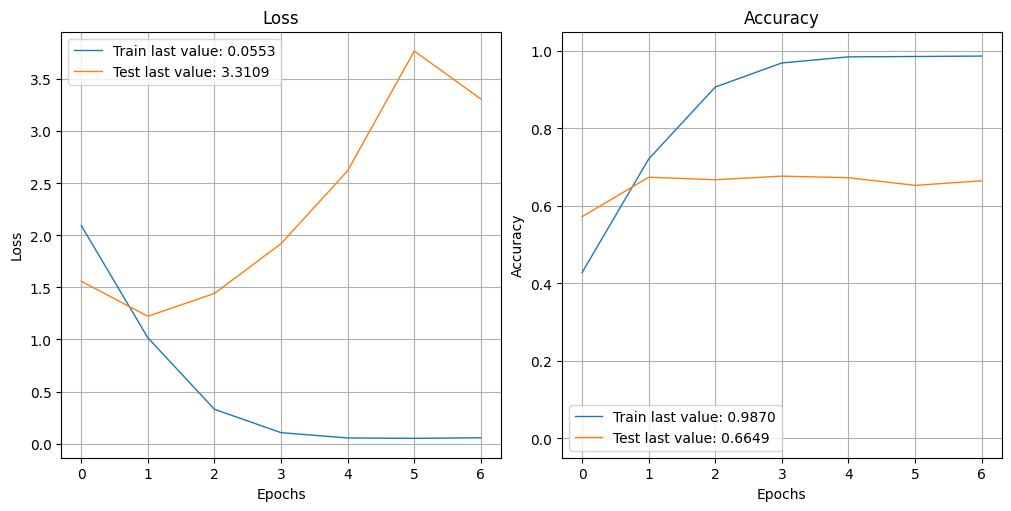

In [37]:
history = models[model_name]["history"]
plot_history(history)

Se puede observar como la tasa de acierto del modelo sobre el conjunto de validación no va en absoluto a la par con la del entrenamiento, por lo que estamos ante un evidente caso de sobreajuste. La pérdida no ha vuelto a bajar desde una de las primeras épocas, y tanto es así que el entrenamiento ha terminado antes de lo previsto gracias a uno de nuestros *callbacks*, que tenía una paciencia de cinco épocas sin mejora antes de detener el proceso.

Como ya hemos comentado en distintos puntos de la práctica, el uso de aumento de datos es una técnica habitual para reducir el sobreajuste a la hora de trabajar con redes neuronales, y no es casualidad que este aparezca en un modelo en el que no se ha realizado. Veremos qué ocurre cuando entrenamos la misma red neuronal haciendo aumento de datos, lo veremos en el siguiente punto.

### Red neuronal convolucional (CNN) sencilla

**A partir de ahora el aumento de datos se aplicará a todos los modelos**

Como se trata de la misma arquitectura pero realizando el aumento de datos, entrenaremos utilizando los mismos hiperparámetros para comparar los resultados:

In [38]:
model_name = "model_simple_cnn"

epochs = 20
callbacks = create_callbacks("best_" + model_name.replace(" ", "_") + ".hdf5", 5)

models[model_name]["history"] = models[model_name]["model"].fit(
    x = train_augmented,
    validation_data = validation,
    epochs = epochs,
    callbacks=callbacks
)

Epoch 1/20
404/404 [==============================] - ETA: 0s - loss: 2.1689 - accuracy: 0.4077
Epoch 1: val_loss improved from inf to 1.52353, saving model to best_model_simple_cnn.hdf5
404/404 [==============================] - 222s 547ms/step - loss: 2.1689 - accuracy: 0.4077 - val_loss: 1.5235 - val_accuracy: 0.5729
Epoch 2/20
404/404 [==============================] - ETA: 0s - loss: 1.4076 - accuracy: 0.6067
Epoch 2: val_loss improved from 1.52353 to 1.18598, saving model to best_model_simple_cnn.hdf5
404/404 [==============================] - 224s 554ms/step - loss: 1.4076 - accuracy: 0.6067 - val_loss: 1.1860 - val_accuracy: 0.6680
Epoch 3/20
404/404 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.6895
Epoch 3: val_loss improved from 1.18598 to 1.18265, saving model to best_model_simple_cnn.hdf5
404/404 [==============================] - 221s 546ms/step - loss: 1.1033 - accuracy: 0.6895 - val_loss: 1.1827 - val_accuracy: 0.6745
Epoch 4/20
404/404 [======

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

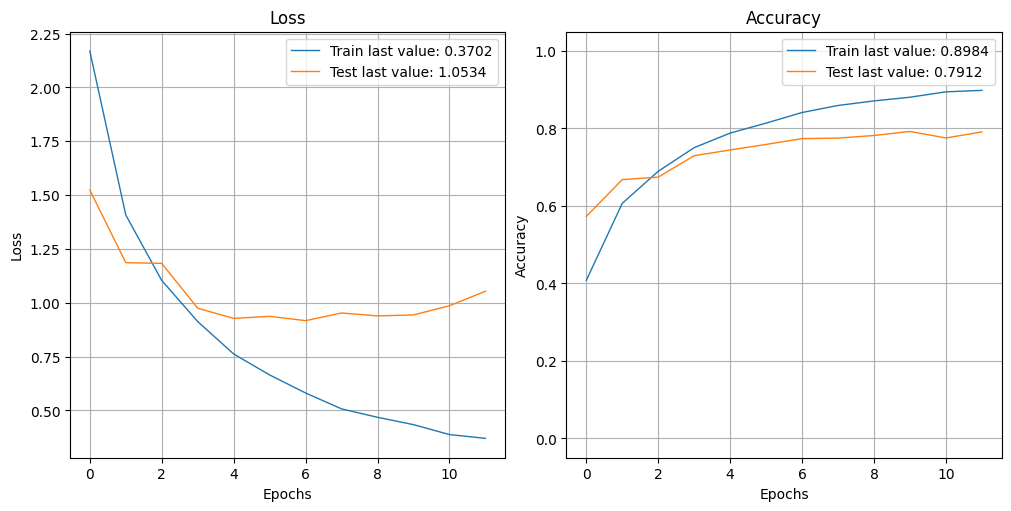

In [39]:
history = models[model_name]["history"]
plot_history(history)

Como podemos observar, utilizar aumento de datos produce una mejora considerable, pues recordemos además que hemos usado la misma arquitectura y hemos entrenado con los mismos hiperparámetros que en el caso anterior. Aunque tampoco obtengamos excelentes resultados, sí son bastante buenos para tratarse de una red neuronal convolucional tan simple. En este caso el proceso también se ha detenido antes, pero no tan pronto.

La tasa de acierto del modelo sobre el conjunto de validación se ha incrementado y el sobreajuste se ha reducido, lo que nos confirma que realizar aumento de datos reduce el sobreajuste, ofreciendo mejores resultados para discriminar ejemplos no observados previamente.

Una vez hemos realizado el aumento de datos y hemos observado una mejora podemos hacernos varias preguntas, ¿Cómo podemos mejorar este modelo? ¿Podemos conseguir mejores resultados con una CNN más compleja? ¿Qué capas adicionales podemos utilizar? Lo veremos a continuación.

### Red neuronal convolucional (CNN) compleja

Vamos a entrenar ahora nuestra red neuronal convocluonal compleja. Recordemos que esta fue creada a partir de la CNN simple, a la que añadimos una capa completamente conectada + *ReLU* seguida de una capa *Dropout*, para obtener un modelo más robusto contra el ruido mediante la regularización.

Como queremos comparar los resultados con los que nos ha ofrecido la red neuronal convolucional simple, utilizaremos la misma configuración a la hora de realizar el entrenamiento.

In [40]:
model_name = "model_complex_cnn"

epochs = 20
callbacks = create_callbacks("best_" + model_name.replace(" ", "_") + ".hdf5", 5)

models[model_name]["history"] = models[model_name]["model"].fit(
    x = train_augmented,
    validation_data = validation,
    epochs = epochs,
    callbacks=callbacks
)

Epoch 1/20
404/404 [==============================] - ETA: 0s - loss: 2.7261 - accuracy: 0.2958
Epoch 1: val_loss improved from inf to 1.79834, saving model to best_model_complex_cnn.hdf5
404/404 [==============================] - 232s 570ms/step - loss: 2.7261 - accuracy: 0.2958 - val_loss: 1.7983 - val_accuracy: 0.5031
Epoch 2/20
404/404 [==============================] - ETA: 0s - loss: 1.8302 - accuracy: 0.4917
Epoch 2: val_loss improved from 1.79834 to 1.52591, saving model to best_model_complex_cnn.hdf5
404/404 [==============================] - 225s 557ms/step - loss: 1.8302 - accuracy: 0.4917 - val_loss: 1.5259 - val_accuracy: 0.5723
Epoch 3/20
404/404 [==============================] - ETA: 0s - loss: 1.5538 - accuracy: 0.5714
Epoch 3: val_loss improved from 1.52591 to 1.20584, saving model to best_model_complex_cnn.hdf5
404/404 [==============================] - 225s 556ms/step - loss: 1.5538 - accuracy: 0.5714 - val_loss: 1.2058 - val_accuracy: 0.6643
Epoch 4/20
404/404 [===

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

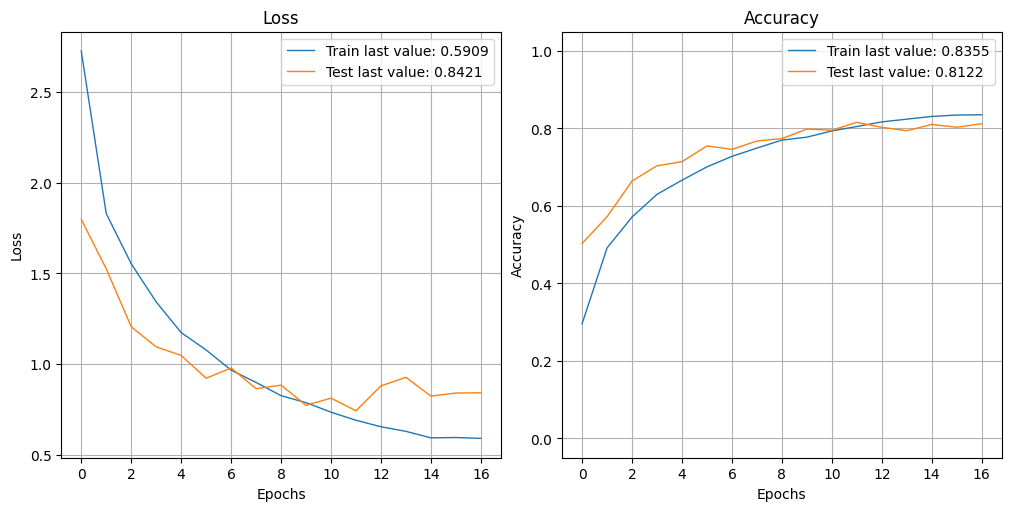

In [41]:
history = models[model_name]["history"]
plot_history(history)

Vemos que nuestras capas adicionales respecto a modelos anteriores han dado sus frutos. Recordemos que estamos creando una red neuronal convolucional "desde cero", por lo que aunque la mejora parezca modesta, realmente es bastante significativa. Por lo tanto, introducir una nueva capa densa seguida de una de *Dropout* ofrece aún mejores resultados. Además de que la tasa de acierto del modelo sobre el conjunto de validación ha mejorado, es importante considerar que la del entrenamiento no ha subido tanto como en el caso anterior, lo que representa un mayor equilibrio.

Con esto zanjamos nuestros modelos de redes neuronales convolucionales, y nos adentramos ahora en el mundo del *Transfer Learning*.

### Redes neuronales utilizando *Transfer Learning*

Para evaluar nuestro modelo de redes neuronales con *Transfer Learning* vamos a seguir el siguiente proceso:

* Sin aplicar *Fine-tuning*

    * Realizar un primer entrenamiento sin entrenar capas adicionales
    * Evaluar los resultados
    
    
* Aplicando *Fine-tuning*

    * Descongelar a partir de la capa 249 para entrenar con los dos primeros inception blocks
    * Recompilar utilizando ahora una tasa de aprendizaje muy reducida para no destruir el conocimiento
    * Reentrenar el modelo después de realizar estos cambios
    * Evaluar los resultados

Comenzamos realizando el primer entrenamiento:

In [42]:
model_name = "model_transfer_learning"

epochs = 20
callbacks = create_callbacks("best_" + model_name.replace(" ", "_") + ".hdf5", 5)

models[model_name]["history"] = models[model_name]["model"].fit(
    x = train_augmented,
    validation_data = validation,
    epochs = epochs,
    callbacks=callbacks
)

Epoch 1/20
404/404 [==============================] - ETA: 0s - loss: 3.2976 - accuracy: 0.2659
Epoch 1: val_loss improved from inf to 2.12246, saving model to best_model_transfer_learning.hdf5
404/404 [==============================] - 239s 572ms/step - loss: 3.2976 - accuracy: 0.2659 - val_loss: 2.1225 - val_accuracy: 0.3907
Epoch 2/20
404/404 [==============================] - ETA: 0s - loss: 2.0606 - accuracy: 0.4073
Epoch 2: val_loss improved from 2.12246 to 2.00745, saving model to best_model_transfer_learning.hdf5
404/404 [==============================] - 229s 567ms/step - loss: 2.0606 - accuracy: 0.4073 - val_loss: 2.0075 - val_accuracy: 0.4243
Epoch 3/20
404/404 [==============================] - ETA: 0s - loss: 1.8386 - accuracy: 0.4688
Epoch 3: val_loss improved from 2.00745 to 1.87367, saving model to best_model_transfer_learning.hdf5
404/404 [==============================] - 227s 563ms/step - loss: 1.8386 - accuracy: 0.4688 - val_loss: 1.8737 - val_accuracy: 0.4614
Epoch

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

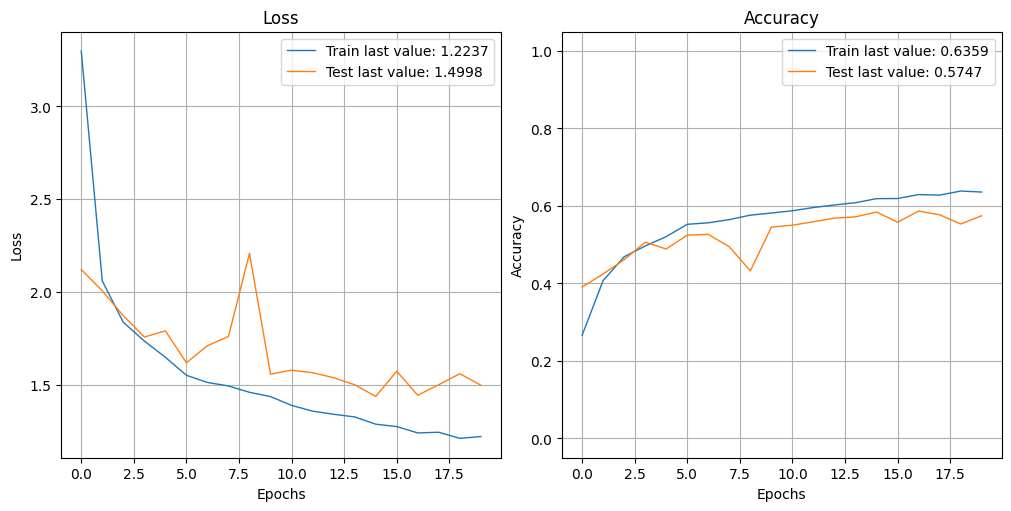

In [43]:
history = models[model_name]["history"]
plot_history(history)

Como podemos observar, no obtenemos un rendimiento extraordinario. Sin embargo, debemos recordar que la "magia" del *Transfer Learning* está en realizar *Fine-tuning*. Ya hemos hecho el primer entreno del clasificador, por lo que ha llegado nuestro tan esperado momento.

En primer lugar congelaremos las 249 primeras capas y descongelaremos el resto. Esto corresponde a entrenar los dos primeros bloques superiores:

In [44]:
for layer in conv_base.layers[:249]:
    layer.trainable = False
for layer in conv_base.layers[249:]:
    layer.trainable = True

Es muy importante volver a compilar antes de reentrenar para que los cambios se apliquen. Además ahora utilizaremos `keras.optimizers.SGD` y reduciremos la tasa de aprendizaje, pues recordemos que simplemente estamos haciendo un pequeño ajuste en los pesos.

In [45]:
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9) # Optimizer
loss = "categorical_crossentropy"  # Loss function
metrics = ["accuracy"]  # List of metrics to be evaluated by the model during training and testing

models[model_name]["model"].compile(optimizer, loss, metrics)

Volvemos a entrenar el modelo:

In [46]:
model_name = "model_transfer_learning"

epochs = 20
callbacks = create_callbacks("best_" + model_name.replace(" ", "_") + ".hdf5", 10)

models[model_name]["history"] = models[model_name]["model"].fit(
    x = train_augmented,
    validation_data = validation,
    epochs = epochs,
    callbacks=callbacks
)

Epoch 1/20
404/404 [==============================] - ETA: 0s - loss: 1.1702 - accuracy: 0.6878
Epoch 1: val_loss improved from inf to 0.69083, saving model to best_model_transfer_learning.hdf5
404/404 [==============================] - 236s 565ms/step - loss: 1.1702 - accuracy: 0.6878 - val_loss: 0.6908 - val_accuracy: 0.8301
Epoch 2/20
404/404 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.8525
Epoch 2: val_loss did not improve from 0.69083
404/404 [==============================] - 239s 591ms/step - loss: 0.5494 - accuracy: 0.8525 - val_loss: 0.9977 - val_accuracy: 0.7795
Epoch 3/20
404/404 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8957
Epoch 3: val_loss improved from 0.69083 to 0.58179, saving model to best_model_transfer_learning.hdf5
404/404 [==============================] - 235s 583ms/step - loss: 0.3838 - accuracy: 0.8957 - val_loss: 0.5818 - val_accuracy: 0.8657
Epoch 4/20
404/404 [==============================] - ETA: 0

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

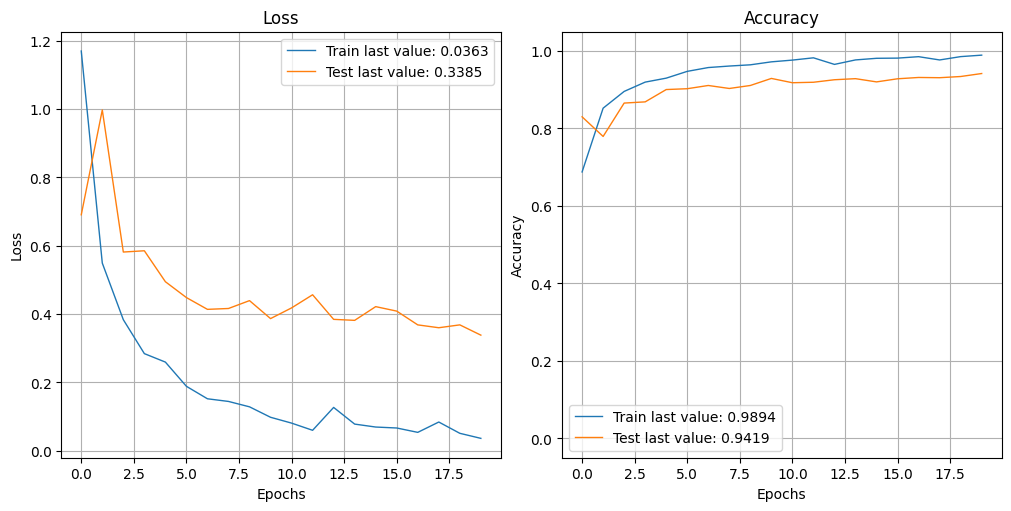

In [47]:
history = models[model_name]["history"]
plot_history(history)

Sin duda obtenemos el mejor de los modelos hasta la fecha. Se puede apreciar un increíble aumento de la tasa de acierto sobre el conjunto de validación en comparación con el primer entrenamiento del modelo, y también respecto a nuestros modelos de redes neuronales convolucionales.

El proceso de *Fine-tuning* en las capas superiores de ha permitido una adaptación eficiente a características específicas de nuestro problema, mejorando la capacidad del modelo para reconocer patrones distintivos incapaces de ser captados por los modelos anteriores. Recordemos que esto se ha llevado a cabo de manera cuidadosa para evitar que se destruya el conocimiento previo. Ajustar las capas superiores mientras se conserva la información valiosa de las capas inferiores ha logrado un equilibrio que da lugar a un gran rendimiento.

Por último, y ya hablando en conjunto, la elección de InceptionV3 y la implementación estratégica del *Fine-tuning* han convergido en un modelo muy efectivo para resolver nuestro problema. Además ofrece una base sólida para futuras iteraciones y mejoras. De hecho, nuestra estrategia de cara a la competición ha sido partir de este modelo hasta obtener los mejores resultados posibles.

# 5. Predicción

Una vez tenemos las redes neuronales entrenadas, simplemente nos queda obtener las predicciones sobre el conjunto de datos de prueba y generar los ficheros de subida para la competición. En nuestro caso cargaremos archivos porque utilizamos, para cada uno de los modelos, el mejor de los que hemos obtenido al entrenarlos, el cuál se ha guardado a través de los *callbacks*.

In [48]:
def write(model, test, path):
    # Generate output predictions for the input samples
    probabilities = model.predict(test)
    labels = [np.argmax(prob) for prob in probabilities]
    labels = classes[labels]

    # Generate the tabular data with the predictions
    function = lambda path: path.split("/")[-1].split("_")[1].split(".")[0]
    iterable = test.filepaths
    identifiers = map(function, iterable)
    identifiers = list(identifiers)
    data = {"Id": identifiers, "Label": labels}
    submission = pd.DataFrame(data).set_index("Id")
    submission.to_csv(path)

In [49]:
best_models_paths = {model: "best_" + model.replace(" ", "_") + ".hdf5" for model in models}
best_models_paths

{'model_simple_cnn_without_data_augmentation': 'best_model_simple_cnn_without_data_augmentation.hdf5',
 'model_simple_cnn': 'best_model_simple_cnn.hdf5',
 'model_complex_cnn': 'best_model_complex_cnn.hdf5',
 'model_transfer_learning': 'best_model_transfer_learning.hdf5'}

In [50]:
for model_name, best_model_path in best_models_paths.items():
    path = model_name.replace(" ", "_") + "_submission.csv"
    model = tf.keras.models.load_model(best_model_path)
    write(model, test, path)

127/127 [==============================] - 14s 101ms/step


# 6. Conclusiones y lecciones aprendidas

Durante el desarrollo de esta práctica hemos explorado varias técnicas y modelos para resolver el problema de la mejor manera posible. La realización de este proyecto, más allá de ser nuestra primera experiencia trabajando con redes neuronales y `TensorFlow`, nos ha permitido aprender una gran cantidad de lecciones y aportarnos un conocimiento muy valioso de cara al futuro y posibles proyectos personales, así como para otras asignaturas.

Algunas de las cosas que hemos aprendido son las siguientes:

- Vuelve a destacar la importancia de la estratificación del conjunto de datos. Después de un problema de clasificación binaria balanceado en las dos primeras prácticas, por fin ha llegado la hora de enfrentarnos a algo más complejo. En estos problemas, una distribución equitativa de clases tanto en entrenamiento como en validación es fundamental, mejorando así la robustez de nuestros modelos frente a las clases desbalanceadas. Pese a que se comprobó que los datos estaban bastante bien divididos al cargarlos directamente con `image_dataset_from_directory`, nosotros quisimos garantizar la estratificación y creamos un nuevo directorio con las particiones correspondientes a través de la librería `split-folders`.

- Hemos explorado las diferentes formas de cargar los datos con `TensorFlow`. Tras implementar varias opciones, finalmente decidimos utilizar generadores de flujo desde directorio, lo cuál nos permite realizar el aumento de datos únicamente en el entrenamiento. Además, conocemos otras estrategias como cargar directamente las imágenes desde directorio en un dataset, o crear el dataset a partir de las imágenes y etiquetas extraídas de DataFrames con las rutas de las imágenes, etc.

- Aplicar aumento de datos ha demostrado ser fundamental para reducir el sobreajuste. La generación de nuevas imágenes a través de rotaciones, traslaciones y otras transformaciones ha mejorado la capacidad del modelo para generalizar a nuevas muestras y ha contribuido significativamente al rendimiento general. Recordemos que el aumento de datos se ha aplicado a todos los modelos menos al primero, en el que se apreciaba claramente cómo se producía sobreajuste. Este se ha realizado a través de un generador de flujo sobre el conjunto de entrenamiento para garantizar que no se aplicaba a los otros conjuntos, aunque en primera instancia utilizamos las capas de preprocesamiento de `TensorFlow` y las añadimos a los modelos secuenciales, por lo que también conocemos esa forma de hacerlo.

- El uso de *callbacks* nos ha permitido quedarnos con el mejor modelo respecto al conjunto de validación y detener el proceso si ya no se producían mejoras. Esto ha sido fundamental a la hora de continuar iterando a para obtener los mejores resultados posibles de cara a la competición.

- La utilización de *Transfer Learning* con modelos preentrenados, como InceptionV3, ha simplificado y mejorado el proceso de entrenamiento. La transferencia de conocimiento desde arquitecturas previamente entrenadas ha permitido aprovechar patrones aprendidos en conjuntos de datos enormes, mejorando la capacidad de nuestro modelo para enfrentarse un problema concreto con una menor cantidad de datos. Aunque cuando no se han descongelado capas los resultados no han sido extraordinarios, ha acabado siendo la base de nuestro mejor modelo.

- El *Fine-tuning* de modelos preentrenados se ha convertido en nuestra mejor estrategia para adaptar las características aprendidas a nuestro problema. Ajustar las capas superiores ha permitido una personalización precisa sin perder la información valiosa de las capas inferiores, gracias en parte a disminuir la tasa de aprendizaje.

- Crear redes neuronales convolucionales desde cero es un proceso muy costoso. Si nos paramos a pensarlo es evidente acabar obteniendo mejores resultados al utilizar modelos preentrenados con una cantidad masiva de datos. Sin embargo, nuestras CNN han ofrecido resultados bastante buenos. Además hemos aprendido sobre la architectura de las redes neuronales convolucionales y hemos comparado diferentes resultados.

- La mejora continua de los modelos ha sido posible gracias a experimentar e iterar constantemente. La realización de esta práctica no ha requerido exactamente un proceso de prueba y error, pero sí ha sido necesario barajar diferentes estrategias y modelos para maximizar el rendimiento, ya que muchas veces grandes resultados pueden surgir de pequeños cambios.

- La competición, aunque consume una gran cantidad de tiempo, nos ha motivado a crear el mejor modelo posible. Además, este proceso también implica un mayor aprendizaje por nuestra parte, ya que hemos recurrido a documentación, libretas de *Kaggle*, repositorios, etc.

Por último, y para despedir esta última práctica, queríamos agradecer a los profesores de la asignatura por la ayuda que nos han ofrecido durante todo el curso. Sin duda ha sido una de las asignaturas con las que más hemos aprendido, y aplicaremos los conocimientos adquiridos de aquí en adelante.